In [1]:
import numpy as np
import csv
import sys
import math
import random
import copy
from sklearn import preprocessing
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import accuracy_score

In [2]:
############## Implementation of Decision Tree Modeling Function ##############

def build_dt(X, Y, attribute_types, maxDepth):
        
    root = bestSplit(X, Y)
    childSplit(root, maxDepth, 1, Y)
    
    return root

def preprocess(X, Y, attribute_types):
    
    M,L = copy.deepcopy(X), copy.deepcopy(Y)
    
    for i in range(len(attribute_types)):
        if attribute_types[i] == 'CATEGORICAL':
            le = preprocessing.LabelEncoder()
            le.fit(["F", "M", "I"])
            for i in range(len(M)):
                M[i][0:1] = le.transform(M[i][0:1])
            
    
    M = np.asarray(M)
    L = np.asarray(L)
    
    M = M.astype(np.float)
    L = L.astype(np.int)
    
    return M, L

def giniScore(splits, classTypes):
    dataNumber = 0.0
    for i in range(len(splits)):
        dataNumber += len(splits[i])   
    giniScore = 0.0
    for i in range(len(splits)):
        
        size = float(len(splits[i]))
        if size == 0.0:
            continue
        
        score = 0.0
        for j in range(len(classTypes)):
            counter = 0
            for k in range(len(splits[i])):
                if(splits[i][k][8] == classTypes[j]):
                    counter += 1
            p= counter / size
            score += p * p
            
        giniScore += (1.0 - score) * (size / dataNumber)
    
    return giniScore

def splitDataset(X, index, value):
    rightSplit = []
    leftSplit  = []
    for i in range(len(X)):
        if X[i][index] < value:
            leftSplit.append(X[i])
        else:
            rightSplit.append(X[i])
    return leftSplit, rightSplit

def bestSplit(X, Y):
    class_values = np.unique(Y)
    bestIndex, bestValue, bestScore, bestSplits = sys.maxsize, sys.maxsize, sys.maxsize, None
    for i in range(len(X[0])-1):
        for j in range(len(X)):
            splits = splitDataset(X, i, X[j][i])
            gini = giniScore(splits, class_values)
            if gini < bestScore:
                bestIndex, bestValue, bestScore, bestSplits = i, X[j][i], gini, splits
    return {'index':bestIndex, 'value':bestValue, 'splits':bestSplits}

def childSplit(node, max_depth, depth, Y):
    
    leftSplit, rightSplit = node['splits']

    if not leftSplit or not rightSplit:
        node['leftSplit'] = leafNode(leftSplit + rightSplit)
        node['rightSplit'] = leafNode(leftSplit + rightSplit)
        return

    if depth >= max_depth:
        node['leftSplit'] = leafNode(leftSplit)
        node['rightSplit'] = leafNode(rightSplit)
        return

    node['leftSplit'] = bestSplit(leftSplit, Y)
    childSplit(node['leftSplit'], max_depth, depth+1, Y)

    node['rightSplit'] = bestSplit(rightSplit, Y)
    childSplit(node['rightSplit'], max_depth, depth+1, Y)

def leafNode(split):
    classes = []
    for i in range(len(split)):
        classes.append(split[i][8])
    return max(set(classes), key=classes.count)

def predict(node, row):
    if float(row[node['index']]) < node['value']:
        if isinstance(node['leftSplit'], dict):
            return predict(node['leftSplit'], row)
        else:
            return node['leftSplit']
    else:
        if isinstance(node['rightSplit'], dict):
            return predict(node['rightSplit'], row)
        else:
            return node['rightSplit']

def predicts(X, tree):
    
    predict_arr = []
    for row in X:
        prediction = predict(tree, row)        
        predict_arr.append(prediction)
    
    return np.asarray(predict_arr)

def predict_dt(dt, X):
    
    predict_arr = []
    for i in range(len(X)):
        prediction = predict(dt, X[i])  
        predict_arr.append(prediction)
    
    return np.asarray(predict_arr)

In [3]:
# Read data

with open('abalone.data', 'r') as f:
    abalone = list(csv.reader(f, delimiter=','))

abalone = np.asarray(abalone)
X = abalone[0:,:9]
Y = abalone[:,8]

X, Y = preprocess(X, Y, ['CATEGORICAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL'])

In [4]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        None
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

4177


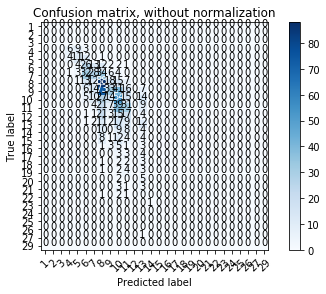

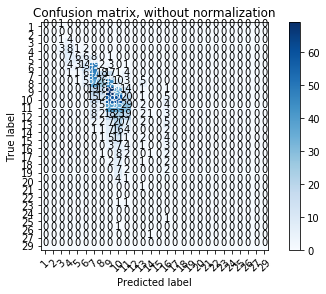

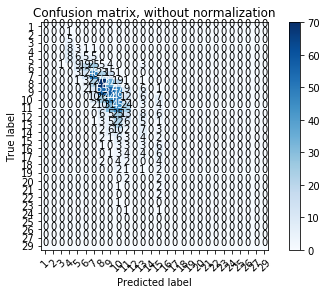

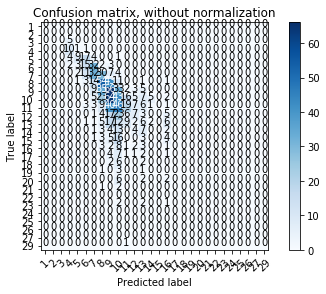

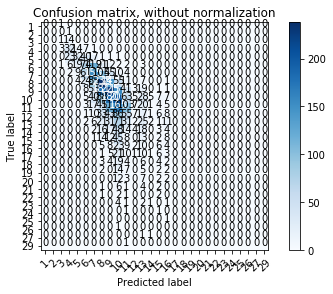

Test Accuracy : %26


In [5]:
############## Implementation of Decision Tree Testing Function ##############

data_size = len(X)

print(data_size)

kf = None

kf = KFold(n_splits=4)

# Suffle train data and train labels
combined = list(zip(X, Y))
random.shuffle(combined)
X, Y = zip(*combined)

total_matrix = None
flag = False
for train, test in kf.split(X):

    Xtrain_data = np.array(X)[train]
    Xtest_data = np.array(X)[test]

    Ytrain_data = np.array(Y)[train]
    Ytest_data = np.array(Y)[test]

    tree = build_dt(Xtrain_data, Ytrain_data, ['CATEGORICAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL'], 5)
    predicted = predict_dt(tree, Xtest_data)
    
    cnf_matrix = confusion_matrix(y_true=Ytest_data, y_pred=predicted, labels=np.unique(Y))
    cnf_matrix.resize(np.unique(Y).shape[0], np.unique(Y).shape[0])
    if(flag == False):
        total_matrix = cnf_matrix
        flag = True
    else:
        total_matrix += cnf_matrix
        
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=np.unique(Y), title='Confusion matrix, without normalization')
    plt.show()

plt.figure()
plot_confusion_matrix(total_matrix, classes=np.unique(Y), title='Confusion matrix, without normalization')
plt.show()

total = 0
for i in range(total_matrix.shape[0]):
    total += total_matrix[i][i]

print("Test Accuracy : %" + str((total*100)//data_size))